# Data Preprocessing

Tasks
1.   Load Kaggle traffic sign data from drive
2.   Unpickle files
3.   Filter out classes not related to speed
4.   Normalize number of samples per class
5.   Split into train / val / test sets
6.   Shuffle datasets
7.   Resize
8.   Normalize pixel values
9.   Make pytorch dataloaders

In [ ]:
import pickle
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Data directory
# Change this as needed
# data_dir = '/content/gdrive/My Drive/2020-21 School Year/APS360/APS360 Project/'
data_dir = '/content/gdrive/My Drive/APS360 Project/'

In [ ]:
# Data loaders

def get_data_loader(batch_size):
    ''' The Kaggle dataset is split into three pickle files: train.pickle,
    valid.pickle, and test.pickle.
    The function will combine the three datasets and resplit them such that the
    resulting split is approximately 70% training, 15% validation, and 15% testing.
    The function filters classes 0-8,13,14,32 only, as they are related to speed.
    The splitting ratio will be applied to each class, to avoid imbalance of 
    classes in the training/validation/testing samples.'''

    classes = ('Speed limit (20km/h)',
            'Speed limit (30km/h)',
            'Speed limit (50km/h)',
            'Speed limit (60km/h)',
            'Speed limit (70km/h)',
            'Speed limit (80km/h)',
            'End of speed limit (80km/h)',
            'Speed limit (100km/h)',
            'Speed limit (120km/h)',
            'Yield',
            'Stop',
            'End of all speed and passing limits')
    # Index of chosen classes in the original dataset
    # In our reconstructed dataset, the same classes will have indexes 0-11
    original_labels = (0,1,2,3,4,5,6,7,8,13,14,32)
    # load pickle files
    # will combine datasets from three seperate pikcle files
    
    with open(data_dir+'train.pickle', 'rb') as file:
        data1 = pickle.load(file)

    with open(data_dir+'valid.pickle', 'rb') as file:
        data2 = pickle.load(file)

    with open (data_dir+'test.pickle', 'rb') as file:
        data3 = pickle.load(file)

    images = np.concatenate((data1['features'], data2['features'], data3['features']))
    labels = np.concatenate((data1['labels'], data2['labels'], data3['labels']))
    images = images.astype(np.float32)
    images = images / 255.0


    # normalization
    for i in range(len(images)):
        images[i] = (images[i]-np.mean(images[i]))/np.std(images[i])



    # shuffle
    np.random.seed(9001)
    indices = list(range(images.shape[0]))
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]

    # split into train /  valid / test
    train_split = 0.7
    valid_split = 0.85

    train_images = images[0:int(train_split*images.shape[0])]
    train_labels = labels[0:int(train_split*images.shape[0])]

    valid_images = images[int(train_split*images.shape[0]):int(valid_split*images.shape[0])]
    valid_labels = labels[int(train_split*images.shape[0]):int(valid_split*images.shape[0])]

    test_images = images[int(valid_split*images.shape[0]):]
    test_labels = labels[int(valid_split*images.shape[0]):]

   # sort into classes
    class_train_images = []
    class_train_labels = []
    for i in range(len(classes)):
        class_train_indices = np.where(train_labels==original_labels[i])[0]
        class_train_images.append(train_images[class_train_indices])
        
        # Don't want the original labels
        # This is where we convert to our own labels: 0-11
        class_train_labels.append(np.full(len(class_train_indices),i)) 

    class_valid_images = []
    class_valid_labels = []
    for i in range(len(classes)):
        class_valid_indices = np.where(valid_labels==original_labels[i])[0]
        class_valid_images.append(valid_images[class_valid_indices])
        
        # Don't want the original labels
        # This is where we convert to our own labels: 0-11
        class_valid_labels.append(np.full(len(class_valid_indices),i)) 

    class_test_images = []
    class_test_labels = []
    for i in range(len(classes)):
        class_test_indices = np.where(test_labels==original_labels[i])[0]
        class_test_images.append(test_images[class_test_indices])

        # Don't want the original labels
        # This is where we convert to our own labels: 0-11
        class_test_labels.append(np.full(len(class_test_indices),i)) 

    # normalize number of samples in each class
    
    # train
    desired_size=int(600*0.7)
    extra_train_images = []
    extra_train_labels = []
    for i in range(len(classes)):
        # Randomly sample from the original class images to duplicate to extra
        if class_train_images[i].shape[0] < desired_size:
            extra_train_images.append(
                class_train_images[i][np.random.randint(
                    low=0,
                    high=class_train_images[i].shape[0],
                    size=desired_size-class_train_images[i].shape[0])])

            # Add random noise to create variation from originals
            # noise_intensity = 0.1

            # extra_train_images[i] = (1-noise_intensity)*extra_train_images[i]+noise_intensity*(255*torch.rand(*extra_train_images[i].shape).detach().numpy())
            # extra_train_images[i] = np.clip(extra_train_images[i], 0, 255)
            

            # add labels for extra samples
            extra_train_labels.append(np.full(extra_train_images[i].shape[0], i))

            # append to original
            class_train_images[i] = np.concatenate((class_train_images[i],extra_train_images[i]))
            class_train_labels[i] = np.concatenate((class_train_labels[i],extra_train_labels[i]))
        else:
            # if more than desired_size images, truncate
            extra_train_images.append([])
            extra_train_labels.append([])
            class_train_images[i] = class_train_images[i][:desired_size]
            class_train_labels[i] = class_train_labels[i][:desired_size]
    # valid
    desired_size=int(600*0.15)
    extra_valid_images = []
    extra_valid_labels = []
    for i in range(len(classes)):
        # Randomly sample from the original class images to duplicate to extra
        if class_valid_images[i].shape[0] < desired_size:
            extra_valid_images.append(
                class_valid_images[i][np.random.randint(
                    low=0,
                    high=class_valid_images[i].shape[0],
                    size=desired_size-class_valid_images[i].shape[0])])


            # add labels for extra samples
            extra_valid_labels.append(np.full(extra_valid_images[i].shape[0], i))

            # append to original
            class_valid_images[i] = np.concatenate((class_valid_images[i],extra_valid_images[i]))
            class_valid_labels[i] = np.concatenate((class_valid_labels[i],extra_valid_labels[i]))
        else:
            # if more than desired_size images, truncate
            extra_valid_images.append([])
            extra_valid_labels.append([])
            class_valid_images[i] = class_valid_images[i][:desired_size]
            class_valid_labels[i] = class_valid_labels[i][:desired_size]

    # test
    desired_size=int(600*0.15)
    extra_test_images = []
    extra_test_labels = []
    for i in range(len(classes)):
        # Randomly sample from the original class images to duplicate to extra
        if class_test_images[i].shape[0] < desired_size:
            extra_test_images.append(
                class_test_images[i][np.random.randint(
                    low=0,
                    high=class_test_images[i].shape[0],
                    size=desired_size-class_test_images[i].shape[0])])
            # Add random noise to create variation from originals
            noise_intensity = 0.1

            extra_train_images[i] = (1-noise_intensity)*extra_train_images[i]+noise_intensity*(1*torch.rand(*extra_train_images[i].shape).detach().numpy())
            extra_train_images[i] = np.clip(extra_train_images[i], 0, 1)

            # Add random noise to create variation from originals
            noise_intensity = 0.05

            extra_test_images[i] = (1-noise_intensity)*extra_test_images[i]+noise_intensity*(1*torch.rand(*extra_test_images[i].shape).detach().numpy())
            extra_test_images[i] = np.clip(extra_test_images[i], 0, 1)
            # add labels for extra samples
            extra_test_labels.append(np.full(extra_test_images[i].shape[0], i))

            # append to original
            class_test_images[i] = np.concatenate((class_test_images[i],extra_test_images[i]))
            class_test_labels[i] = np.concatenate((class_test_labels[i],extra_test_labels[i]))
        else:
            # if more than desired_size images, truncate
            extra_test_images.append([])
            extra_test_labels.append([])
            class_test_images[i] = class_test_images[i][:desired_size]
            class_test_labels[i] = class_test_labels[i][:desired_size]

    # combine class arrays
    train_images = np.concatenate(class_train_images)
    train_labels = np.concatenate(class_train_labels)

    valid_images = np.concatenate(class_valid_images)
    valid_labels = np.concatenate(class_valid_labels)

    test_images = np.concatenate(class_test_images)
    test_labels = np.concatenate(class_test_labels)

    # shuffle again
    indices = list(range(train_images.shape[0]))
    np.random.shuffle(indices)
    train_images = train_images[indices]
    train_labels = train_labels[indices]
    
    indices = list(range(valid_images.shape[0]))
    np.random.shuffle(indices)
    valid_images = valid_images[indices]
    valid_labels = valid_labels[indices]
   
    indices = list(range(test_images.shape[0]))
    np.random.shuffle(indices)
    test_images = test_images[indices]
    test_labels = test_labels[indices]

    # SHADMAN'S CHANGES ABOVE THIS

    # make into torch datasets
    train_image_tensor = torch.Tensor(train_images.transpose(0,3,1,2))
    train_label_tensor = torch.Tensor(train_labels)
    
    val_image_tensor = torch.Tensor(valid_images.transpose(0,3,1,2))
    val_label_tensor = torch.Tensor(valid_labels)
    
    test_image_tensor = torch.Tensor(test_images.transpose(0,3,1,2))
    test_label_tensor = torch.Tensor(test_labels)
   
    trainset = TensorDataset(train_image_tensor, train_label_tensor)
    valset = TensorDataset(val_image_tensor, val_label_tensor)
    testset = TensorDataset(test_image_tensor, test_label_tensor)



    # make data loaders
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        num_workers=1)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        num_workers=1)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        num_workers=1)
    
    return train_loader, val_loader, test_loader, classes 

In [ ]:
batch_size = 32
train_loader, val_loader, test_loader, classes = get_data_loader (batch_size)
print (classes)
print (len(train_loader))
print (len(val_loader))
print (len(test_loader))

('Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'Yield', 'Stop', 'End of all speed and passing limits')
158
34
34


In [ ]:
# Check one batch
dataiter = iter(val_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[[[-0.5331847  -0.69084597 -0.7302613  ... -0.5331847  -0.65143067
   -0.7696766 ]
  [-0.5331847  -0.69084597 -0.7302613  ...  0.01862992  0.09746056
   -0.25727734]
  [-0.5331847  -0.69084597 -0.7302613  ... -0.21786202 -0.25727734
   -0.3361081 ]
  ...
  [ 2.6988723   2.5806262   2.659457   ... -0.61201537 -0.5331847
   -0.5331847 ]
  [ 2.7777028   2.6200416   2.659457   ... -0.5726     -0.5331847
   -0.5331847 ]
  [ 2.6988723   2.5806262   2.541211   ... -0.61201537 -0.5331847
   -0.5726    ]]

 [[-0.49376938 -0.69084597 -0.7302613  ... -0.29669267 -0.41493872
   -0.49376938]
  [-0.5331847  -0.69084597 -0.7302613  ...  0.25512186  0.33395252
   -0.02078541]
  [-0.5331847  -0.69084597 -0.7302613  ...  0.01862992 -0.02078541
   -0.09961606]
  ...
  [ 2.2653036   2.186473    2.304719   ... -0.5726     -0.5726
   -0.5726    ]
  [ 2.2653036   2.2258883   2.2653036  ... -0.5331847  -0.5331847
   -0.5726    ]
  [ 2.2653036   2.1470575   2.1470575  ... -0.5726     -0.5331847
   -0.5331847 ]

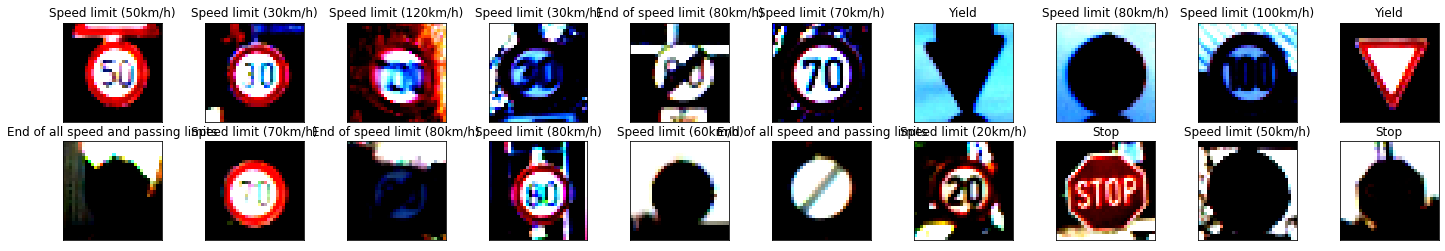

In [ ]:
images, labels = dataiter.next()
images = images.numpy()
labels = labels.int()
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])
print (images[1])

In [ ]:
# close all figures to prevent memory leak
plt.close('all')

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)//(max_val - min_val)             #this is kinda brilliant
    return norm_labels




#TRAIN

Tasks:
 - Calculate training accuracy
 - Calculate training loss
 - Calculate validation accuracy
 - Calculate validation loss
 - Store weights in epoch files (we may have to be smart about WHERE we're saving this so that we don't clutter up the drive)
 - Get accuracy of model after training is complete
 - Plot everything


In [ ]:
def train(model, train_loader, val_loader, batch_size=27, num_epochs=21, learning_rate = 0.001):

    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_acc, val_acc, train_loss, val_loss = [], [], [], []

    # training
    print ("Training Started...\n")
    if torch.cuda.is_available():
        print("U S I N G   C U D A \n\n")

    for epoch in range(num_epochs):                                     # the number of iterations
        sum_train_loss = 0.0
        sum_val_loss = 0.0

        n = 0                                                           # Number of training iterations in this epoch
        m = 0                                                           # Number of validation iterations in this epoch

        for imgs, labels in iter(train_loader):
                
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)                                           # forward pass
            loss = criterion(out, labels.long())                               # compute the total loss
            loss.backward()                                             # backward pass (compute parameter updates)
            optimizer.step()                                            # make the updates for each parameter
            optimizer.zero_grad()                                       # a clean up step for PyTorch
            sum_train_loss += loss.item() 
            n += 1
        
        for imgs, labels in iter(val_loader):
            
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()                                    # cudafication for speeeeed

            out = model(imgs)                                            
            loss = criterion(out, labels.long())                               # compute loss with Cross Entropy
            sum_val_loss += loss.item()
            m += 1

        # track accuracy and loss
        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, val_loader))
        train_loss.append(sum_train_loss/n)
        val_loss.append(sum_val_loss/m)

        ################################################################################################################
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch+1) 
        torch.save(model.state_dict(), model_path)

        print('Epoch: ', epoch + 1,                                                 #A little text formatting goes a long way
              '\t Training acc:', round(train_acc[-1],4),
              '\t Val acc:%.4f' % val_acc[-1],
              '\t Training loss:%.4f' % train_loss[-1],
              '\t Val loss:%.4f' % val_loss[-1])

    return train_acc, val_acc, train_loss, val_loss

def get_accuracy(model, data_loader):

  correct = 0
  total = 0
  for imgs, labels in data_loader:
      
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()

      output = model(imgs)
      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]

  return correct / total




def plot_training_curve(train_acc, val_acc, train_loss, val_loss):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt

    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim                                                     # For gradient descent
import matplotlib.pyplot as plt
import numpy as np

#Baseline

In [ ]:
class BaseANN(nn.Module):
  
  def __init__(self):
    super(BaseANN, self).__init__()

    self.name = "BaseANN"
    self.num_classes = 12

    #model layers
    self.fc1 = nn.Linear(32*32*3, 32)
    self.fc2 = nn.Linear(32, self.num_classes)
  
  def forward(self, x):
    #flatten image for input into fc layers
    x = x.view(-1, 32*32*3)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = x.squeeze(1)

    return x

Training Started...

U S I N G   C U D A 


Epoch:  1 	 Training acc: 0.6141 	 Val acc:0.5611 	 Training loss:1.7904 	 Val loss:1.2620
Epoch:  2 	 Training acc: 0.7885 	 Val acc:0.7259 	 Training loss:0.8413 	 Val loss:0.7712
Epoch:  3 	 Training acc: 0.8754 	 Val acc:0.8000 	 Training loss:0.5147 	 Val loss:0.5414
Epoch:  4 	 Training acc: 0.9137 	 Val acc:0.8380 	 Training loss:0.3471 	 Val loss:0.4752
Epoch:  5 	 Training acc: 0.9218 	 Val acc:0.8333 	 Training loss:0.2623 	 Val loss:0.4872
Epoch:  6 	 Training acc: 0.9454 	 Val acc:0.8667 	 Training loss:0.2140 	 Val loss:0.4080
Epoch:  7 	 Training acc: 0.9536 	 Val acc:0.8731 	 Training loss:0.1810 	 Val loss:0.4120
Epoch:  8 	 Training acc: 0.9627 	 Val acc:0.8843 	 Training loss:0.1543 	 Val loss:0.3867
Epoch:  9 	 Training acc: 0.9544 	 Val acc:0.8731 	 Training loss:0.1350 	 Val loss:0.3788
Epoch:  10 	 Training acc: 0.9706 	 Val acc:0.8981 	 Training loss:0.1088 	 Val loss:0.3445
Epoch:  11 	 Training acc: 0.9633 	 Val acc:0

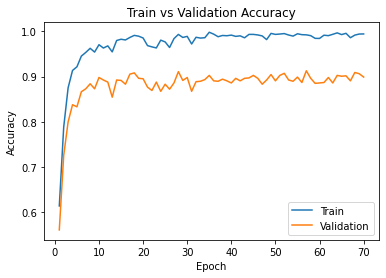

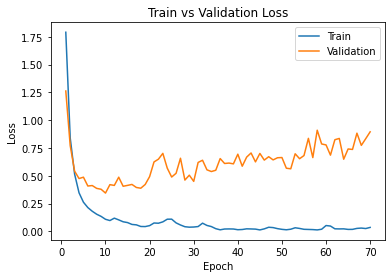

In [ ]:
model4 = BaseANN()
use_cuda = False

batch_size = 256
train_loader, val_loader, test_loader, classes = get_data_loader(batch_size)

train_acc, val_acc, train_loss, val_loss = train(model4, train_loader, val_loader, batch_size=256, num_epochs=70, learning_rate = 0.0055)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

#Primary Model Architecture and Testing

Tasks:
 - Build a CNN model with 3 convolutional layers and 3 fully connected layers
 - Perform a sanity check to test if model is capable of overfitting
 - Use training code to test on model and tune hyperparameters to obtain best results
 - Print and Plot Results
 - Try 10 different hyperparameter settings and compare


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim                                                     # For gradient descent
import matplotlib.pyplot as plt
import numpy as np

# Creating a CNN
class SignClassifier(nn.Module):

    def __init__(self):
        super(SignClassifier, self).__init__()
        self.name = "Net"                                                       
        self.conv1 = nn.Conv2d(3,5,5)                                           # First kernel is a 5 by 5, 3 color channels, it has output of 5    -> given 32x32x3, you are left with 28x28x5
        self.pool = nn.MaxPool2d(2,2)                                           # Max pooling layer with kernel size 2 and stride 2                 -> you are left with 14x14x5
        self.conv2 = nn.Conv2d(5,10,3)                                          # Second kernel is 5 by 5, it changes input depth from 5 to 10      -> you are left with 10x10x10
        self.conv3 = nn.Conv2d(10,12,5)                                         # Third kernel is 5 by 5, it changes input depth from 10 to 12      -> you are left with 6x6x12
                                                                                
        self.fc1 = nn.Linear(8*8*12, 200)                                       # Fully Connected Layers
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100,12)                                             # 12 possible outputs

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))                                    # Apply first kernel, then activation function, then max pooling 
        x = F.relu(self.conv2(x))                                               # Apply second kernel, then activation function
        x = F.relu(self.conv3(x))                                               # Apply second kernel, then activation function
        x = x.view(-1, 8*8*12)                                                  # flatten tensor for ANN portion
        x = F.relu(self.fc1(x))                                                 # Apply activation function on first fully connected layer
        x = F.relu(self.fc2(x))                                                 # Apply activation function on second fully connected layer
        x = self.fc3(x)                                                         # final activation function is included with criterion
        x = x.squeeze(1) # Flatten to [batch_size]
        return x


In [16]:
model_1 = SignClassifier()

Training Started...

U S I N G   C U D A 


Epoch:  1 	 Training acc: 0.8062 	 Val acc:0.7824 	 Training loss:1.1906 	 Val loss:0.6170
Epoch:  2 	 Training acc: 0.9458 	 Val acc:0.9222 	 Training loss:0.3330 	 Val loss:0.2586
Epoch:  3 	 Training acc: 0.9573 	 Val acc:0.9398 	 Training loss:0.1721 	 Val loss:0.1978
Epoch:  4 	 Training acc: 0.9758 	 Val acc:0.9593 	 Training loss:0.0980 	 Val loss:0.1428
Epoch:  5 	 Training acc: 0.9871 	 Val acc:0.9630 	 Training loss:0.0758 	 Val loss:0.1302
Epoch:  6 	 Training acc: 0.9766 	 Val acc:0.9519 	 Training loss:0.0464 	 Val loss:0.1872
Epoch:  7 	 Training acc: 0.9927 	 Val acc:0.9704 	 Training loss:0.0318 	 Val loss:0.1289
Epoch:  8 	 Training acc: 0.9907 	 Val acc:0.9676 	 Training loss:0.0281 	 Val loss:0.1804
Epoch:  9 	 Training acc: 0.9808 	 Val acc:0.9685 	 Training loss:0.0369 	 Val loss:0.1436
Epoch:  10 	 Training acc: 0.9954 	 Val acc:0.9685 	 Training loss:0.0378 	 Val loss:0.1127
Epoch:  11 	 Training acc: 0.9986 	 Val acc:0

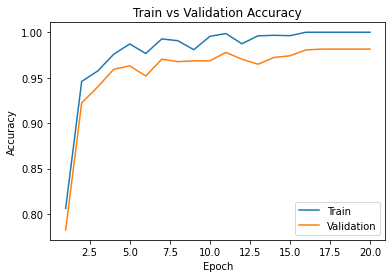

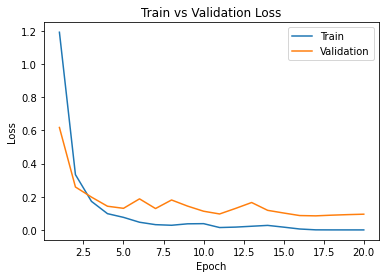

In [ ]:
model_1 = SignClassifier()
use_cuda = False


batch_size = 32
train_loader, val_loader, test_loader, classes = get_data_loader(batch_size)

train_acc, val_acc, train_loss, val_loss = train(model_1, train_loader, val_loader, batch_size=32, num_epochs=20, learning_rate = 0.001)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

Training Started...

U S I N G   C U D A 


Epoch:  1 	 Training acc: 0.4298 	 Val acc:0.3935 	 Training loss:2.2948 	 Val loss:1.7916
Epoch:  2 	 Training acc: 0.6611 	 Val acc:0.6333 	 Training loss:1.3764 	 Val loss:1.0756
Epoch:  3 	 Training acc: 0.7829 	 Val acc:0.7639 	 Training loss:0.8230 	 Val loss:0.7217
Epoch:  4 	 Training acc: 0.8468 	 Val acc:0.8296 	 Training loss:0.5702 	 Val loss:0.5340
Epoch:  5 	 Training acc: 0.8948 	 Val acc:0.8824 	 Training loss:0.4406 	 Val loss:0.4091
Epoch:  6 	 Training acc: 0.9153 	 Val acc:0.9037 	 Training loss:0.3550 	 Val loss:0.3617
Epoch:  7 	 Training acc: 0.9304 	 Val acc:0.9120 	 Training loss:0.2951 	 Val loss:0.3116
Epoch:  8 	 Training acc: 0.9401 	 Val acc:0.9213 	 Training loss:0.2521 	 Val loss:0.2779
Epoch:  9 	 Training acc: 0.9468 	 Val acc:0.9324 	 Training loss:0.2162 	 Val loss:0.2510
Epoch:  10 	 Training acc: 0.9538 	 Val acc:0.9361 	 Training loss:0.1889 	 Val loss:0.2279
Epoch:  11 	 Training acc: 0.9621 	 Val acc:0

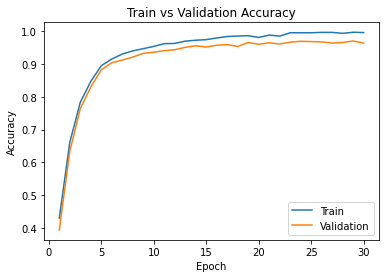

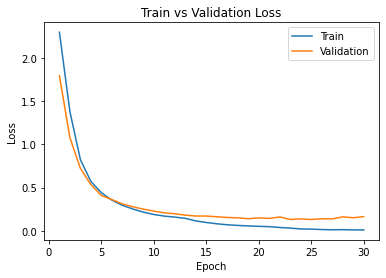

In [ ]:
model_2 = SignClassifier()
use_cuda = False

batch_size = 256
train_loader, val_loader, test_loader, classes = get_data_loader(batch_size)

train_acc, val_acc, train_loss, val_loss = train(model_2, train_loader, val_loader, batch_size=256, num_epochs=30, learning_rate = 0.0009)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

Training Started...

U S I N G   C U D A 


Epoch:  1 	 Training acc: 0.4016 	 Val acc:0.3750 	 Training loss:2.2646 	 Val loss:1.8148
Epoch:  2 	 Training acc: 0.5494 	 Val acc:0.5657 	 Training loss:1.5570 	 Val loss:1.2885
Epoch:  3 	 Training acc: 0.6893 	 Val acc:0.6769 	 Training loss:1.1097 	 Val loss:0.9403
Epoch:  4 	 Training acc: 0.7421 	 Val acc:0.7222 	 Training loss:0.8072 	 Val loss:0.7779
Epoch:  5 	 Training acc: 0.8256 	 Val acc:0.8222 	 Training loss:0.6247 	 Val loss:0.5492
Epoch:  6 	 Training acc: 0.8619 	 Val acc:0.8639 	 Training loss:0.4949 	 Val loss:0.4292
Epoch:  7 	 Training acc: 0.9 	 Val acc:0.8833 	 Training loss:0.4038 	 Val loss:0.3544
Epoch:  8 	 Training acc: 0.9155 	 Val acc:0.9037 	 Training loss:0.3195 	 Val loss:0.3000
Epoch:  9 	 Training acc: 0.9335 	 Val acc:0.9185 	 Training loss:0.2651 	 Val loss:0.2535
Epoch:  10 	 Training acc: 0.9373 	 Val acc:0.9167 	 Training loss:0.2218 	 Val loss:0.2562
Epoch:  11 	 Training acc: 0.9486 	 Val acc:0.92

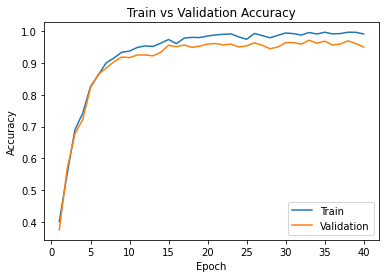

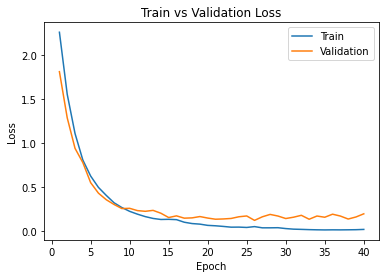

In [ ]:
model_3 = SignClassifier()
model_3.name = "model3"
use_cuda = False

batch_size = 256
train_loader, val_loader, test_loader, classes = get_data_loader(batch_size)

train_acc, val_acc, train_loss, val_loss = train(model_3, train_loader, val_loader, batch_size=256, num_epochs=40, learning_rate = 0.001)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

Training Started...

U S I N G   C U D A 


Epoch:  1 	 Training acc: 0.2601 	 Val acc:0.2481 	 Training loss:2.4730 	 Val loss:2.4503
Epoch:  2 	 Training acc: 0.3304 	 Val acc:0.3213 	 Training loss:2.3982 	 Val loss:2.3191
Epoch:  3 	 Training acc: 0.401 	 Val acc:0.3657 	 Training loss:2.1797 	 Val loss:2.0174
Epoch:  4 	 Training acc: 0.4651 	 Val acc:0.4306 	 Training loss:1.8416 	 Val loss:1.7048
Epoch:  5 	 Training acc: 0.5595 	 Val acc:0.5361 	 Training loss:1.5590 	 Val loss:1.4593
Epoch:  6 	 Training acc: 0.6149 	 Val acc:0.6120 	 Training loss:1.3436 	 Val loss:1.2627
Epoch:  7 	 Training acc: 0.6526 	 Val acc:0.6500 	 Training loss:1.1854 	 Val loss:1.1175
Epoch:  8 	 Training acc: 0.6813 	 Val acc:0.6852 	 Training loss:1.0649 	 Val loss:1.0045
Epoch:  9 	 Training acc: 0.7145 	 Val acc:0.7222 	 Training loss:0.9677 	 Val loss:0.9133
Epoch:  10 	 Training acc: 0.7403 	 Val acc:0.7444 	 Training loss:0.8865 	 Val loss:0.8361
Epoch:  11 	 Training acc: 0.7688 	 Val acc:0.

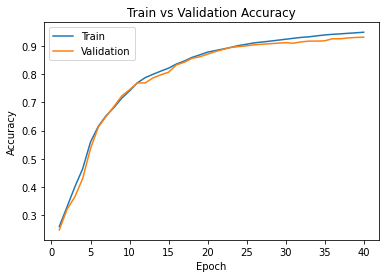

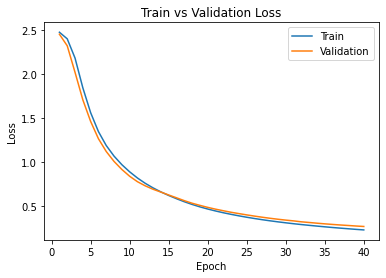

In [ ]:
model_4 = SignClassifier()
use_cuda = False

batch_size = 256
train_loader, val_loader, test_loader, classes = get_data_loader(batch_size)

train_acc, val_acc, train_loss, val_loss = train(model_4, train_loader, val_loader, batch_size=256, num_epochs=40, learning_rate = 0.00016)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

Training Started...

U S I N G   C U D A 


Epoch:  1 	 Training acc: 0.276 	 Val acc:0.2593 	 Training loss:2.4705 	 Val loss:2.4427
Epoch:  2 	 Training acc: 0.3335 	 Val acc:0.3120 	 Training loss:2.3751 	 Val loss:2.2729
Epoch:  3 	 Training acc: 0.4105 	 Val acc:0.3713 	 Training loss:2.1013 	 Val loss:1.9171
Epoch:  4 	 Training acc: 0.4948 	 Val acc:0.4722 	 Training loss:1.7409 	 Val loss:1.6041
Epoch:  5 	 Training acc: 0.5917 	 Val acc:0.5704 	 Training loss:1.4594 	 Val loss:1.3537
Epoch:  6 	 Training acc: 0.6389 	 Val acc:0.6269 	 Training loss:1.2556 	 Val loss:1.1735
Epoch:  7 	 Training acc: 0.6702 	 Val acc:0.6778 	 Training loss:1.1087 	 Val loss:1.0402
Epoch:  8 	 Training acc: 0.7056 	 Val acc:0.7102 	 Training loss:0.9955 	 Val loss:0.9409
Epoch:  9 	 Training acc: 0.7339 	 Val acc:0.7435 	 Training loss:0.9039 	 Val loss:0.8554
Epoch:  10 	 Training acc: 0.7633 	 Val acc:0.7565 	 Training loss:0.8271 	 Val loss:0.7830
Epoch:  11 	 Training acc: 0.7837 	 Val acc:0.

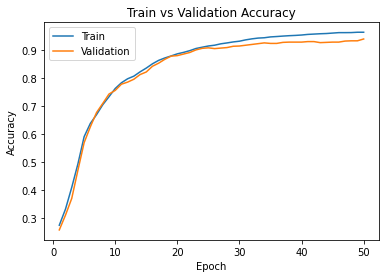

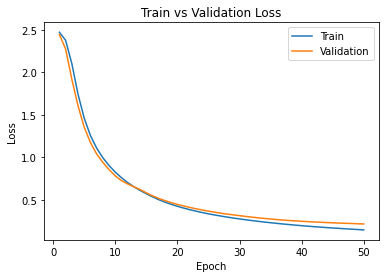

In [ ]:
model_5 = SignClassifier()
use_cuda = False

batch_size = 256
train_loader, val_loader, test_loader, classes = get_data_loader(batch_size)

train_acc, val_acc, train_loss, val_loss = train(model_5, train_loader, val_loader, batch_size=256, num_epochs=50, learning_rate = 0.00018)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

Training Started...

U S I N G   C U D A 


Epoch:  1 	 Training acc: 0.177 	 Val acc:0.1593 	 Training loss:2.4724 	 Val loss:2.4504
Epoch:  2 	 Training acc: 0.3306 	 Val acc:0.3056 	 Training loss:2.3821 	 Val loss:2.2810
Epoch:  3 	 Training acc: 0.3986 	 Val acc:0.3611 	 Training loss:2.1136 	 Val loss:1.9236
Epoch:  4 	 Training acc: 0.47 	 Val acc:0.4398 	 Training loss:1.7122 	 Val loss:1.5745
Epoch:  5 	 Training acc: 0.5496 	 Val acc:0.5250 	 Training loss:1.4377 	 Val loss:1.3642
Epoch:  6 	 Training acc: 0.6032 	 Val acc:0.5861 	 Training loss:1.2619 	 Val loss:1.2023
Epoch:  7 	 Training acc: 0.655 	 Val acc:0.6491 	 Training loss:1.1180 	 Val loss:1.0668
Epoch:  8 	 Training acc: 0.7062 	 Val acc:0.6926 	 Training loss:0.9920 	 Val loss:0.9447
Epoch:  9 	 Training acc: 0.75 	 Val acc:0.7259 	 Training loss:0.8807 	 Val loss:0.8409
Epoch:  10 	 Training acc: 0.7806 	 Val acc:0.7657 	 Training loss:0.7859 	 Val loss:0.7591
Epoch:  11 	 Training acc: 0.804 	 Val acc:0.7787 	

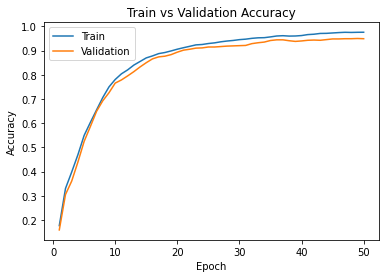

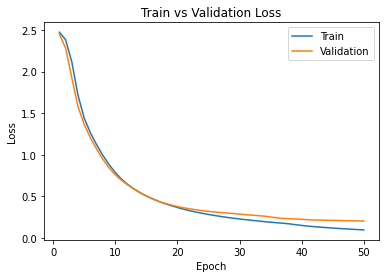

In [ ]:
model_6 = SignClassifier()
use_cuda = False

batch_size = 256
train_loader, val_loader, test_loader, classes = get_data_loader(batch_size)

train_acc, val_acc, train_loss, val_loss = train(model_6, train_loader, val_loader, batch_size=256, num_epochs=50, learning_rate = 0.0002)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

Training Started...

U S I N G   C U D A 


Epoch:  1 	 Training acc: 0.3208 	 Val acc:0.2991 	 Training loss:2.4431 	 Val loss:2.3351
Epoch:  2 	 Training acc: 0.4498 	 Val acc:0.4148 	 Training loss:2.0484 	 Val loss:1.7181
Epoch:  3 	 Training acc: 0.5694 	 Val acc:0.5509 	 Training loss:1.5017 	 Val loss:1.3505
Epoch:  4 	 Training acc: 0.6552 	 Val acc:0.6370 	 Training loss:1.2210 	 Val loss:1.1097
Epoch:  5 	 Training acc: 0.7192 	 Val acc:0.6981 	 Training loss:1.0130 	 Val loss:0.9153
Epoch:  6 	 Training acc: 0.7659 	 Val acc:0.7435 	 Training loss:0.8417 	 Val loss:0.7747
Epoch:  7 	 Training acc: 0.7952 	 Val acc:0.7852 	 Training loss:0.7137 	 Val loss:0.6813
Epoch:  8 	 Training acc: 0.8268 	 Val acc:0.8102 	 Training loss:0.6213 	 Val loss:0.6050
Epoch:  9 	 Training acc: 0.849 	 Val acc:0.8398 	 Training loss:0.5492 	 Val loss:0.5469
Epoch:  10 	 Training acc: 0.8716 	 Val acc:0.8546 	 Training loss:0.4892 	 Val loss:0.4863
Epoch:  11 	 Training acc: 0.8885 	 Val acc:0.

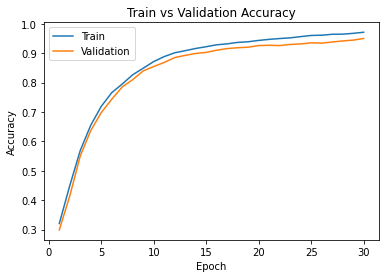

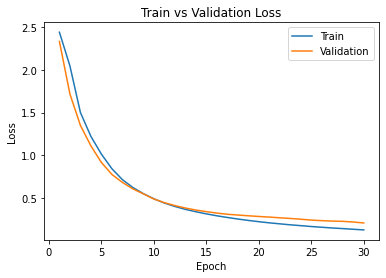

In [ ]:
model_7 = SignClassifier()
use_cuda = False

batch_size = 128
train_loader, val_loader, test_loader, classes = get_data_loader(batch_size)

train_acc, val_acc, train_loss, val_loss = train(model_7, train_loader, val_loader, batch_size=128, num_epochs=30, learning_rate = 0.0002)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

Training Started...

U S I N G   C U D A 


Epoch:  1 	 Training acc: 0.2629 	 Val acc:0.2463 	 Training loss:2.4562 	 Val loss:2.3783
Epoch:  2 	 Training acc: 0.4024 	 Val acc:0.3880 	 Training loss:2.1410 	 Val loss:1.8747
Epoch:  3 	 Training acc: 0.4984 	 Val acc:0.4852 	 Training loss:1.6750 	 Val loss:1.5203
Epoch:  4 	 Training acc: 0.5766 	 Val acc:0.5500 	 Training loss:1.4223 	 Val loss:1.3274
Epoch:  5 	 Training acc: 0.6323 	 Val acc:0.6056 	 Training loss:1.2490 	 Val loss:1.1670
Epoch:  6 	 Training acc: 0.6742 	 Val acc:0.6694 	 Training loss:1.1057 	 Val loss:1.0394
Epoch:  7 	 Training acc: 0.7121 	 Val acc:0.7028 	 Training loss:0.9908 	 Val loss:0.9385
Epoch:  8 	 Training acc: 0.7375 	 Val acc:0.7278 	 Training loss:0.8981 	 Val loss:0.8579
Epoch:  9 	 Training acc: 0.7657 	 Val acc:0.7491 	 Training loss:0.8233 	 Val loss:0.7908
Epoch:  10 	 Training acc: 0.7855 	 Val acc:0.7694 	 Training loss:0.7626 	 Val loss:0.7366
Epoch:  11 	 Training acc: 0.798 	 Val acc:0.

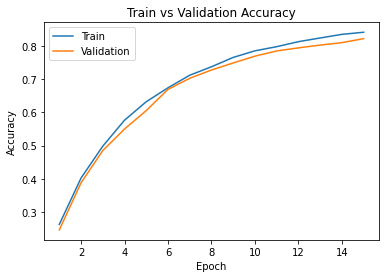

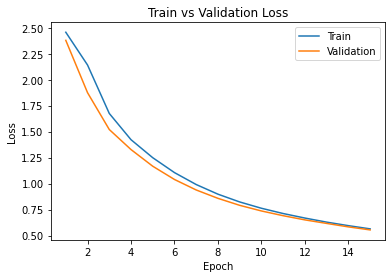

In [ ]:
model_8 = SignClassifier()
use_cuda = False

batch_size = 64
train_loader, val_loader, test_loader, classes = get_data_loader(batch_size)

train_acc, val_acc, train_loss, val_loss = train(model_8, train_loader, val_loader, batch_size=64, num_epochs=15, learning_rate = 0.00008)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

In [ ]:
def get_class_accuracies(model, data_loader):

  corrects= [0]*12
  totals = [0]*12
  for imgs, labels in data_loader:
      
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()

      output = model(imgs)

      for i in range(len(labels)):
        label = int(labels[i].item())
        pred = torch.argmax(output[i])
        totals[label] += 1
        if pred == label:
          corrects[label] += 1

  acc = [ i / j for i, j in zip(corrects, totals)]
      
  return acc

In [17]:
testModel = SignClassifier()
use_cuda=False
model_path = ('/content/gdrive/My Drive/APS360 Project/the best model/'+get_model_name(model_1.name, 32, 0.001, 18))


state = torch.load(model_path)
testModel.load_state_dict(state)
total_test_acc = get_accuracy(testModel, test_loader)
class_test_acc = get_class_accuracies(testModel, test_loader)
print(f"The overall test accuracy is: {total_test_acc}\n")

for i in range(len(class_test_acc)):
  print("Test accuracy for {}: {:.4f}".format(classes[i], class_test_acc[i]))

The overall test accuracy is: 0.9740740740740741

Test accuracy for Speed limit (20km/h): 0.9444
Test accuracy for Speed limit (30km/h): 0.9667
Test accuracy for Speed limit (50km/h): 0.9778
Test accuracy for Speed limit (60km/h): 0.9556
Test accuracy for Speed limit (70km/h): 0.9778
Test accuracy for Speed limit (80km/h): 0.9778
Test accuracy for End of speed limit (80km/h): 0.9778
Test accuracy for Speed limit (100km/h): 0.9889
Test accuracy for Speed limit (120km/h): 0.9778
Test accuracy for Yield: 0.9889
Test accuracy for Stop: 0.9889
Test accuracy for End of all speed and passing limits: 0.9667


In [18]:
def get_confusion(model, data_loader):
  confusion = np.zeros((12,12))
  for imgs, labels in data_loader:
    output = model(imgs)
    for i in range(len(labels)):
      label = int(labels[i].item())
      pred = torch.argmax(output[i])
      confusion[label, pred] += 1
  return confusion
  

In [ ]:
print(get_confusion(testModel, test_loader))

[[85.  0.  0.  0.  2.  0.  0.  0.  1.  0.  0.  2.]
 [ 0. 87.  2.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. 88.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 86.  0.  0.  0.  0.  0.  1.  1.  2.]
 [ 0.  1.  0.  0. 88.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0. 88.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 88.  1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0. 89.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  2. 88.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0. 89.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0. 89.  0.]
 [ 0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0. 87.]]


### Demo Setup


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from torchvision.transforms import ToTensor
import torchvision

In [22]:
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/APS360 Project/Test_Images/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [25]:
#load the day test images
day_path = path + 'day_drive/'
day_imgs = []

for i in sorted(os.listdir(day_path)):
    img = Image.open(day_path + i)
    img = ToTensor()(img).unsqueeze(0)
    img = img.numpy()
    img = img.astype(np.float32)
    img = img / 255.0


    # normalization
    
    img = (img-np.mean(img))/np.std(img)
    img = torch.from_numpy(img)
    print()
    day_imgs.append(img)


In [26]:
# check the predictions
for img in day_imgs:
  out = testModel(img)
  idx = torch.argmax(out)
  print(classes[idx])

Yield
Speed limit (70km/h)
Speed limit (20km/h)
Stop
Speed limit (70km/h)


In [27]:
#load the night test images
night_path = path + 'night_drive/'
night_imgs = []

for i in sorted(os.listdir(night_path)):
    img = Image.open(night_path + i)
    img = ToTensor()(img).unsqueeze(0)
    img = img.numpy()
    img = img.astype(np.float32)
    # normalization
    img = (img-np.mean(img))/np.std(img)
    img = torch.from_numpy(img)
    night_imgs.append(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


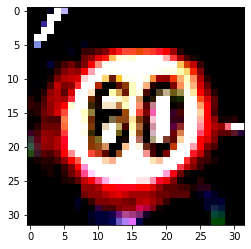

In [28]:
#Just to make sure Normalization worked as intended
night_imgs[0].size()
plt.imshow(night_imgs[0].squeeze(0).permute(1,2,0))


In [30]:
#check the predictions

for i in range(len(night_imgs)):
  #normalized_image=torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)).forward(img)
  # if i==0:
  #   out = model(night_imgs[1])
  #else:
  out = testModel(night_imgs[i])
  idx = torch.argmax(out)
  print(classes[idx])

Speed limit (50km/h)
Speed limit (50km/h)
Yield
End of speed limit (80km/h)
Speed limit (80km/h)
Speed limit (70km/h)
Speed limit (60km/h)
